In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Set random seeds
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_numbers(text = str) -> str:
  """
  Removes numbers from the text.

  Parameters
  ----------
  text : str
    The string to remove numbers from.

  Returns
  -------
  str
    The string with numbers removed.
  """

  # Remove numbers
  return re.sub(r'\b\d+\b', '', text)

def remove_punctuation(text = str) -> str:
  """
  Removes punctuation from the text.

  Parameters
  ----------
  text : str
    The string to remove punctuation from.

  Returns
  -------
  str
    The string with punctuation removed.
  """

  # Remove punctuation
  return re.sub(r'[^\w\s]', '', text)

def lemmatize(text = str) -> str:
  """
  Lemmatizes the text.

  Parameters
  ----------
  text : str
    The string to lemmatize.

  Returns
  -------
  str
    The lemmatized string.
  """

  # Helper function for part of speech
  def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Get tokens
  words = text.split()

  # Get part of speech
  pos_tags = pos_tag(words)

  # Lemmatize each word
  words_lemmatize = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

  # Join words back together
  return " ".join(words_lemmatize)

def stemming(text = str) -> str:
  """
  Stems the text.

  Parameters
  ----------
  text : str
    The string to stem.

  Returns
  -------
  str
    The stemmed string.
  """

  # Initialize stemmer
  stemmer = PorterStemmer()

  # Get tokens
  words = text.split()

  # Stem each word
  words_stem = [stemmer.stem(word) for word in words]

  # Join words back together
  return " ".join(words_stem)

def preprocessing(df = pd.DataFrame, preprocessing_functions = list) -> pd.DataFrame:
  """
  Preprocesses the text in the dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  preprocessing_functions : list
    The list of preprocessing functions to apply.

  Returns
  -------
  pd.DataFrame
    The preprocessed dataframe.
  """

  # Initialize dataframe
  df_copy = df.copy()

  # Apply preprocessing functions
  for preprocessing_function in preprocessing_functions:
    df_copy.map(preprocessing_function)

  return df_copy

In [ ]:
# Evaluation functions

def classifier_metrics(y_true = list, y_pred = list, model_name = "Model"):
  """
  Prints the metrics for a classifier.

  Parameters
  ----------
  y_true : list
    The true labels.
  y_pred : list
    The predicted labels.
  model_name : str
    The name of the model.

  Returns
  -------
  None
  """

  # Print metrics
  print(model_name)
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("Precision: ", precision_score(y_true, y_pred, pos_label = 'sports'))
  print("Recall: ", recall_score(y_true, y_pred, pos_label = 'sports'))
  print("F1 score: ", f1_score(y_true, y_pred, pos_label = 'sports'))
  print()

def plot_roc_curve(y_true = list, y_pred_prob = list, model_name = "Model"):
    """
    Plots the ROC curve for a binary classifier.

    Parameters
    ----------
    y_true : list
        The true labels.
    y_pred_prob : list
        The predicted probabilities.
    model_name : str
        The name of the model.

    Returns
    -------
    None
    """

    # Binarize string labels
    lb = LabelBinarizer(pos_label = 1)
    y_true = lb.fit_transform(y_true)

    # Compute the ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color = 'blue', lw = 2, label = f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color = 'black', lw = 2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc = "lower right")
    plt.grid(alpha = 0.7)
    plt.show()

SVM model (gamma = 2000)
Accuracy:  0.9396551724137931
Precision:  0.9429347826086957
Recall:  0.9429347826086957
F1 score:  0.9429347826086957

Confusion matrix for SVM model (gamma = 2000):


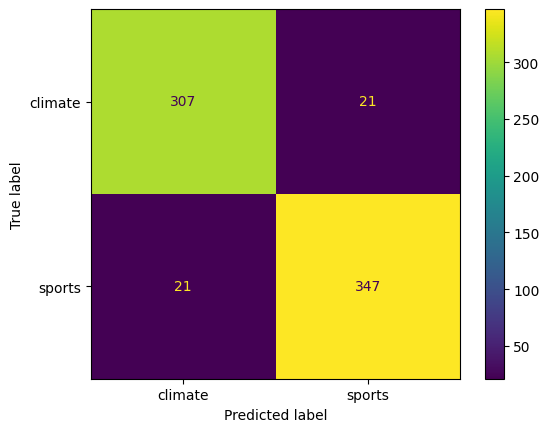


[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]

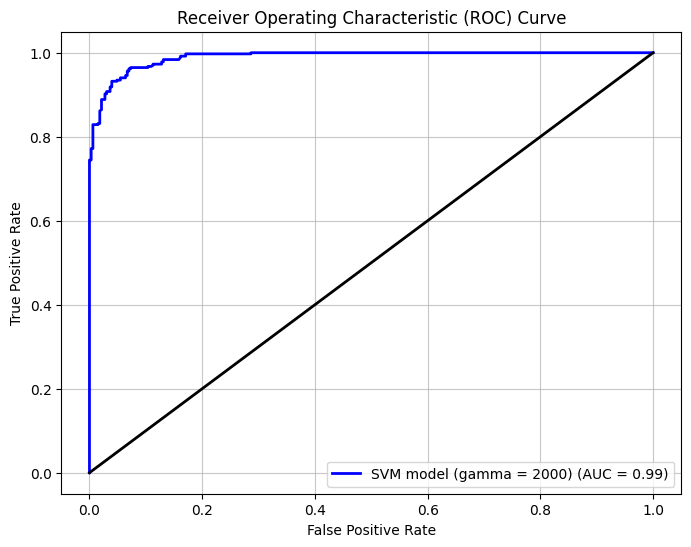

Logistic Regression with penalty = None
Accuracy:  0.9425287356321839
Precision:  0.9456521739130435
Recall:  0.9456521739130435
F1 score:  0.9456521739130435

Confusion matrix for logistic regression with penalty = None:


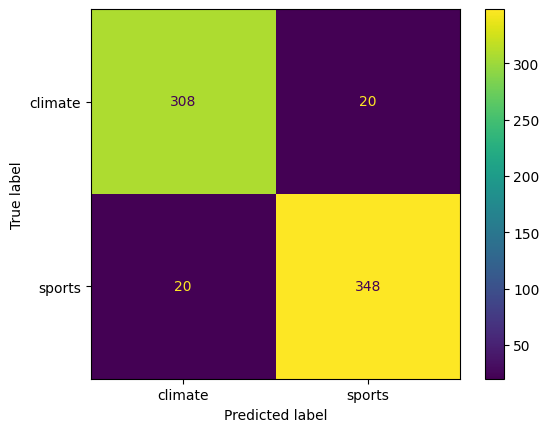


[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]

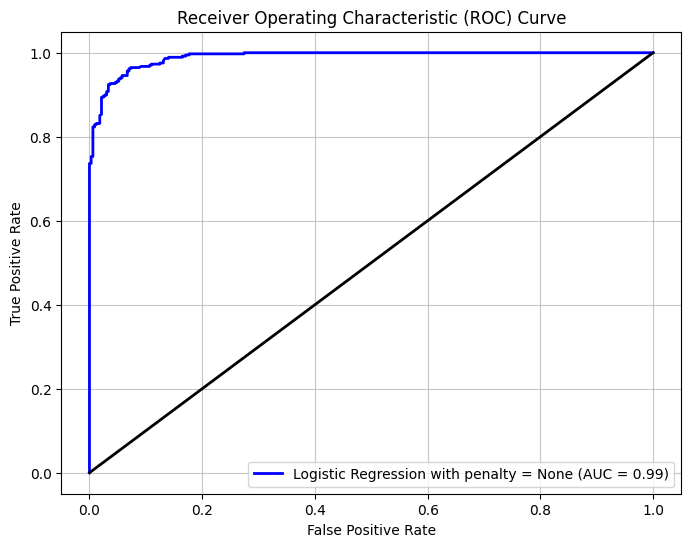

Naive Bayes
Accuracy:  0.9022988505747126
Precision:  0.875
Recall:  0.9510869565217391
F1 score:  0.9114583333333334

Confusion matrix for naive bayes:


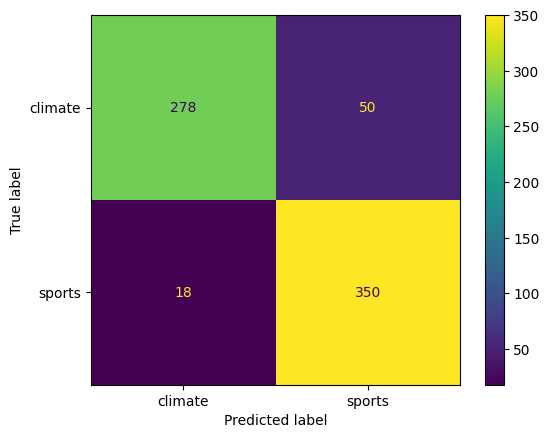


[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]

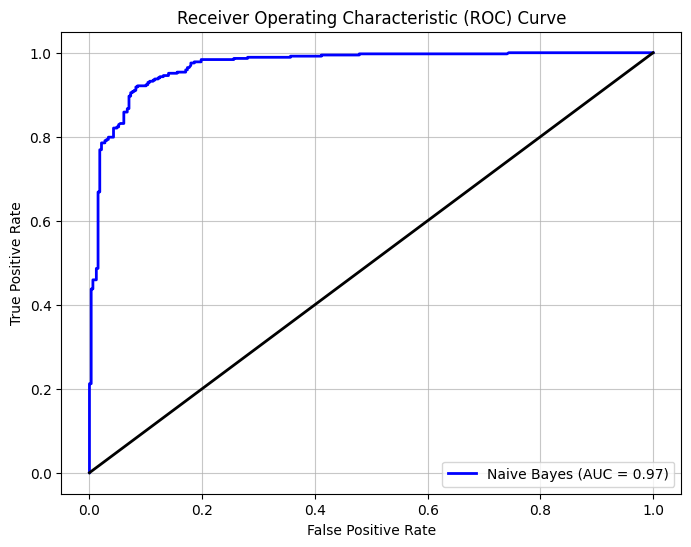

In [ ]:
# Manual pipeline
# TODO: Organize and create automatic pipeline

# Set seeds
np.random.seed(42)
random.seed(42)

# Load in dataset
df = pd.read_csv("Project1-ClassificationDataset.csv")

# Split dataset
train, test = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

# Preprocessing
# Make sure clean function is first
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]
X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer with min_df = 3
mindf = 3
count_vect = CountVectorizer(stop_words = 'english', min_df = mindf)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Number of columns should be the same for train and test sets
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

# Apply LSI with k = 25
k = 25 ### PARAMETER
svd = TruncatedSVD(n_components = k, random_state = 42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Train linear SVM with gamma = 2000
gamma = 2000 ### PARAMETER
svm_model = LinearSVC(C = gamma, random_state = 42)
y_pred = svm_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_prob = svm_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)

# Evaluate SVM model
classifier_metrics(test['root_label'], y_pred, "SVM model (gamma = " + str(gamma) + ")")
print("Confusion matrix for SVM model (gamma = " + str(gamma) + "):")
cm = confusion_matrix(test['root_label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_prob, "SVM model (gamma = " + str(gamma) + ")")

# Train Logistic regression with no penalty
chosen_penalty = None ### PARAMETER
model = LogisticRegression(random_state = 42, penalty = chosen_penalty)
model.fit(X_train_reduced, train['root_label'])
y_pred = model.predict(X_test_reduced)
y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred, "Logistic Regression with penalty = " + str(chosen_penalty))
print("Confusion matrix for logistic regression with penalty = " + str(chosen_penalty) + ":")
cm = confusion_matrix(test['root_label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_prob, "Logistic Regression with penalty = " + str(chosen_penalty))

# Train Naive Bayes model
# Naive Bayes model
model = GaussianNB()
model.fit(X_train_reduced, train['root_label'])
y_pred = model.predict(X_test_reduced)
y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred, "Naive Bayes")
print("Confusion matrix for naive bayes:")
cm = confusion_matrix(test['root_label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_prob, "Naive Bayes")


[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]


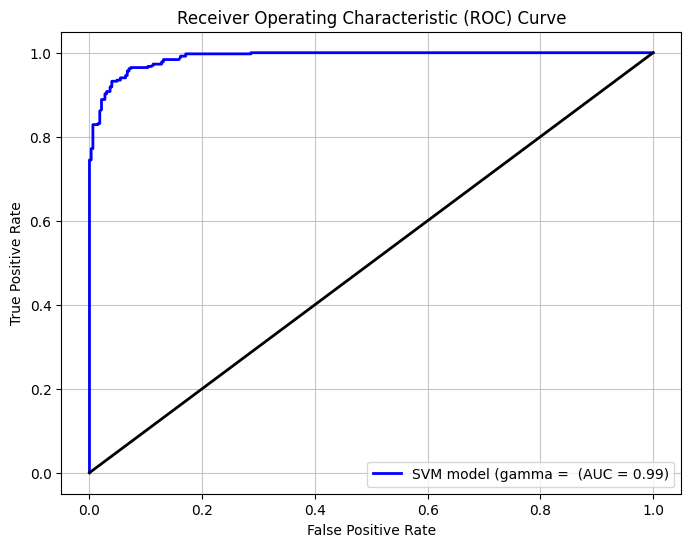

In [ ]:
plot_roc_curve(test['root_label'], y_pred_prob, "SVM model (gamma = ")
